In [1]:
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

In [2]:
dtype = torch.FloatTensor
''' Net Settings'''
In_Nodes = 55553 ###number of genes
Hidden_Nodes = 143 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.03, 0.01, 0.001, 0.00075]
L2_Lambda = [0.1, 0.01, 0.005, 0.001]
num_epochs = 10 ###for grid search
Num_EPOCHS = 50 ###for training
###sub-network setup
Dropout_Rate = [0.7, 0.5]

In [3]:
from Data_extraction import output_df2, x_df2  

In [4]:
# print(len(ytime_train))

In [5]:
data = pd.concat([x_df2,output_df2],axis=1)

def split_indices(n, val_pct1, val_pct2):
	n1 = int(val_pct1*n)
	n2 = int(val_pct2*n)
	idxs = np.random.permutation(n)
	train, val, test = idxs[:n1], idxs[n1:n2], idxs[n2:]
	train.sort(), val.sort(), test.sort()
	return(train, val, test)

train_index, val_index, test_index = split_indices(len(data),0.6, 0.8)
print(train_index)
print(val_index)
print(test_index)
x, ytime, yevent, age = load_data(data, dtype)

# data_train = data.iloc[train_index]
# data_val = data.iloc[val_index]
# data_test = data.iloc[test_index]
# x_train, ytime_train, yevent_train, age_train = load_data(data_train, dtype)
# x_valid, ytime_valid, yevent_valid, age_valid = load_data(data_val, dtype)
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  16  17  22  23  24
  25  27  28  29  31  32  33  34  37  38  40  41  42  44  45  47  48  49
  52  53  54  56  57  60  61  62  63  66  67  73  76  79  80  82  83  84
  85  87  88  90  94 100 104 105 106 107 108 109 110 111 112 113 114 117
 120 126 127 128 129 130 131 132 133 134 135 137 139 140 141 143 145 147
 148 149 152 158 159 161 162 163 165 166 167 168 173 174 175 176]
[ 13  18  19  26  30  39  46  50  55  65  68  69  78  86  89  93  96  99
 101 102 115 118 119 121 122 125 142 144 146 153 155 157 169 171 172]
[ 14  15  20  21  35  36  43  51  58  59  64  70  71  72  74  75  77  81
  91  92  95  97  98 103 116 123 124 136 138 150 151 154 156 160 164 170]


In [6]:
from Data_Loader import CustomDataset
batch_size=10
data2 = CustomDataset(x, ytime, yevent, age)
train_loader = DataLoader(data2, batch_size, sampler=train_index)
val_loader = DataLoader(data2, batch_size, sampler=val_index)

In [7]:
# print(np.shape(torch.cat((x_train, age_train),1)))
# for i in train_sampler: 
#     print(i)
# for k in train_sampler: 
#     print(k)
# # print(data_train2['x_train'])
# k=0
# for batch in train_loader: 
#     x_train_b, ytime_train_b, yevent_train_b, age_train_b = batch
#     print(np.shape(x_train_b))
    # x_train, ytime_train, yevent_train, age_train = batch
#     print(batch)
#  print(len(torch.cat((x_train, ytime_train, yevent_train, age_train),1)))
# print(data_train2['vital_status'])
# for batch in train_loader: 
#     print(batch)


In [8]:
opt_l2_loss = 0
opt_lr_loss = 0
opt_do_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

In [9]:
for l2 in L2_Lambda:
	for lr in Initial_Learning_Rate:
		for do in Dropout_Rate:
			history_train, history_val = trainCox_nnet(train_loader, \
				val_loader, \
				In_Nodes, Hidden_Nodes, Out_Nodes, \
				lr, l2, num_epochs, do)
			loss_train2 = [k['loss'] for k in history_train]
			if loss_train2[-1] =='nan': 
				break
			elif loss_train2[-1] < opt_loss:
				opt_l2_loss = l2
				opt_lr_loss = lr
				opt_do_loss = do
				opt_loss = loss_train2[-1]
				# opt_c_index_tr = c_index_tr
				# opt_c_index_va = c_index_va
			print ("L2: ", l2, "LR: ", lr, "Loss in Validation: ", opt_loss)

Epoch [0], loss: nan, c_index: 0.0000
Epoch [1], loss: nan, c_index: 0.0000
Epoch [2], loss: nan, c_index: 0.0000
Epoch [3], loss: nan, c_index: 0.0000
Epoch [4], loss: nan, c_index: 0.0000
Epoch [5], loss: nan, c_index: 0.0000
Epoch [6], loss: nan, c_index: 0.0000
Epoch [7], loss: nan, c_index: 0.0000
Epoch [8], loss: nan, c_index: 0.0000
Epoch [9], loss: nan, c_index: 0.0000
Epoch [10], loss: nan, c_index: 0.0000
L2:  0.1 LR:  0.03 Loss in Validation:  tensor([inf])
Epoch [0], loss: nan, c_index: 0.0000
Epoch [1], loss: nan, c_index: 0.0000
Epoch [2], loss: nan, c_index: 0.0000
Epoch [3], loss: nan, c_index: 0.0000
Epoch [4], loss: nan, c_index: 0.0000
Epoch [5], loss: nan, c_index: 0.0000
Epoch [6], loss: nan, c_index: 0.0000
Epoch [7], loss: nan, c_index: 0.0000
Epoch [8], loss: nan, c_index: 0.0000
Epoch [9], loss: nan, c_index: 0.0000
Epoch [10], loss: nan, c_index: 0.0000
L2:  0.1 LR:  0.03 Loss in Validation:  tensor([inf])
Epoch [0], loss: nan, c_index: 0.0000
Epoch [1], loss:

In [10]:
print(opt_l2_loss, opt_lr_loss, opt_do_loss)

0.001 0.001 0.5


In [11]:
###train Cox-PASNet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
history_train, history_val = trainCox_nnet(train_loader, \
			val_loader, \
			In_Nodes, Hidden_Nodes, Out_Nodes, \
			opt_lr_loss, opt_l2_loss, Num_EPOCHS, opt_do_loss)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)



Epoch [0], loss: 3.0143, c_index: 0.3354
Epoch [1], loss: 1.5498, c_index: 0.3354
Epoch [2], loss: 1.8460, c_index: 0.3354
Epoch [3], loss: 2.4906, c_index: 0.3354
Epoch [4], loss: 1.9191, c_index: 0.3069
Epoch [5], loss: 2.0416, c_index: 0.3161
Epoch [6], loss: 2.2125, c_index: 0.3161
Epoch [7], loss: 2.0603, c_index: 0.3363
Epoch [8], loss: 2.0029, c_index: 0.3462
Epoch [9], loss: 1.9416, c_index: 0.3263
Epoch [10], loss: 2.0945, c_index: 0.3355
Epoch [11], loss: 2.4084, c_index: 0.3462
Epoch [12], loss: 2.1705, c_index: 0.3539
Epoch [13], loss: 2.0151, c_index: 0.4162
Epoch [14], loss: 1.8502, c_index: 0.5300
Epoch [15], loss: 1.9369, c_index: 0.3801
Epoch [16], loss: 2.3431, c_index: 0.3122
Epoch [17], loss: 2.1959, c_index: 0.3138
Epoch [18], loss: 2.1449, c_index: 0.4041
Epoch [19], loss: 2.0968, c_index: 0.3808
Epoch [20], loss: 2.0858, c_index: 0.3416
Epoch [21], loss: 2.1567, c_index: 0.3909
Epoch [22], loss: 2.0053, c_index: 0.4239
Epoch [23], loss: 2.1032, c_index: 0.4850
Ep

In [12]:
# print(history_train)
# print(history_val)

In [13]:
loss_train2 = [k['loss'] for k in history_train]
loss_val2 = [k['loss'] for k in history_val] 
c_index_tr2 = [k['c_index'] for k in history_train]
c_index_val2 = [k['c_index'] for k in history_val]

epoch = np.arange(0,Num_EPOCHS+1)


In [14]:
# loss_train2 = [k.detach().numpy() for k in loss_train]
# loss_test2 = [k.detach().numpy() for k in loss_test]
# c_index_tr2 = [k.detach().numpy() for k in c_index_tr]
# c_index_te2 = [k.detach().numpy() for k in c_index_te]
# epoch = np.arange(0,Num_EPOCHS+2,2)

In [15]:
print(loss_train2)
# print(len(yevent_train))

[3.483790397644043, 2.102374315261841, 1.5068916082382202, 1.759832739830017, 1.87688410282135, 1.5839054584503174, 1.616434097290039, 1.6155530214309692, 1.4860621690750122, 1.304370403289795, 1.25837242603302, 1.2022229433059692, 1.2679414749145508, 1.0150806903839111, 0.9035519957542419, 0.8410600423812866, 0.8151980042457581, 0.7570247054100037, 0.771257221698761, 0.705918550491333, 0.6862906813621521, 0.703738272190094, 0.6339458227157593, 0.6206567883491516, 0.6749763488769531, 0.5741763114929199, 0.6946188807487488, 0.6413479447364807, 0.7313249707221985, 0.7688548564910889, 0.9775720834732056, 0.7345966696739197, 0.8405317664146423, 0.608130693435669, 0.5575577020645142, 0.5881269574165344, 1.2566934823989868, 1.544670820236206, 1.0098483562469482, 0.6966341137886047, 0.5206819176673889, 0.5827054381370544, 0.6285219192504883, 0.6197458505630493, 0.5544160604476929, 0.5400365591049194, 0.536476731300354, 0.5171306133270264, 0.49136802554130554, 0.4466812014579773, 0.44115737080

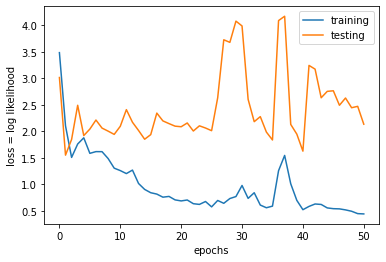

In [16]:
import matplotlib.pyplot as plt 
plt.plot(epoch, loss_train2, label = 'training')
plt.plot(epoch, loss_val2, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()


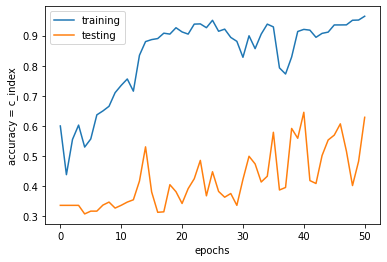

In [17]:
import matplotlib.pyplot as plt 
plt.plot(epoch, c_index_tr2, label = 'training')
plt.plot(epoch, c_index_val2, label = 'testing')
plt.ylabel('accuracy = c_index')
plt.xlabel('epochs')
plt.legend()


In [18]:
print(c_index_te[-1])

NameError: name 'c_index_te' is not defined

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
get_default_device()

device(type='cpu')

In [ ]:
from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index
from Model2 import Cox_nnet

net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes)
net.eval()
test_pred = net(x_test, age_test)
eval_loss = []
eval_cindex=[]
eval_loss.append(neg_par_log_likelihood(test_pred, ytime_test, yevent_test).view(1,))
eval_cindex.append(c_index(test_pred, ytime_test, yevent_test))

In [ ]:
print(eval_loss, eval_cindex)

[tensor([7.7761], grad_fn=<ViewBackward0>)] [tensor(0.4251)]


In [ ]:
len(x_test)

36